In [1]:
%load_ext autoreload
%cd /workdir/ComfyUI/
%autoreload 2
    
from comfywr.csd_lib import load_image, cn_preprocess, control_net_set_create, \
    control_net_set_apply_hint, init_extra_nodes, load_sd_checkpoint, load_cn, load_upscale_model, load_lora, \
    load_clip_vision, load_ipadapter, run_marigold_depth_estimation, image_scale, ultimate_sd_upscale, clip_encode, \
    ip_adapter_apply, load_depth_anything_v2, run_depth_anything_v2, image_scale_by

/workdir/ComfyUI


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
/usr/local/lib/python3.11/dist-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/usr/local/lib/python3.11/dist-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please

DWPose: Onnxruntime with acceleration providers detected


/workdir/custom_nodes/comfyui_marigold/nodes.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  empty_text_embed = torch.load(os.path.join(script_directory, "empty_text_em

In [3]:
import importlib
Mesh = importlib.import_module('custom_nodes.ComfyUI-3D-Pack.mesh_processer.mesh').Mesh

In [4]:
mesh_path = '/workdir/ComfyUI/output/Unique3d_v2.1/initial2.obj'
mesh = Mesh.load(mesh_path)

[load_obj] use texture from: /workdir/ComfyUI/output/Unique3d_v2.1/initial2_albedo.png
[load_obj] load texture: (1024, 1024, 3)
[Mesh loading] v: torch.Size([99909, 3]), f: torch.Size([198950, 3])
[Mesh loading] vn: torch.Size([99909, 3]), fn: torch.Size([198950, 3])


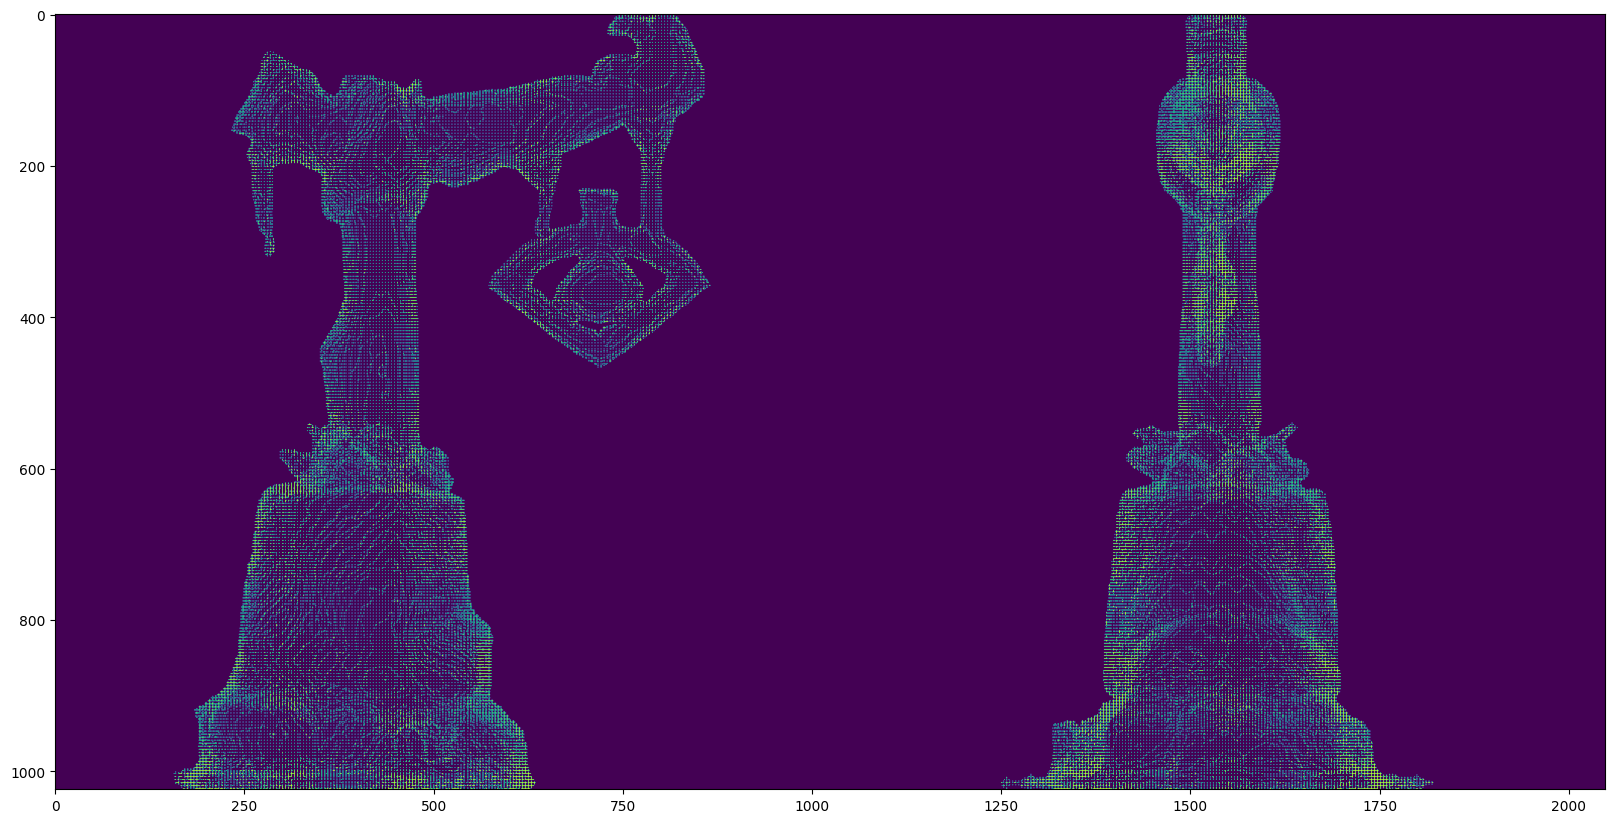

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt 
pt = mesh.convert_to_pointcloud()
IMG_RES = 1024
img = np.zeros((1024, 1024), dtype=np.float32)
points = ((pt.points + 0.5) * (IMG_RES - 1)).astype(int)
points.shape
# points = points[:1000]
views = []

xs, ys = points[:, [0, 1]].T
v = img.copy()
v[IMG_RES - 1 - ys, xs] = 1
views.append(v)

zs, ys = points[:, [2, 1]].T
v = img.copy()
v[IMG_RES - 1 - ys, zs] = 1
views.append(v)

plt.figure(figsize=(20,20))
plt.imshow(np.concatenate(views, axis=1) * 255)
plt.show()

In [6]:
!pip install "pyglet<2"

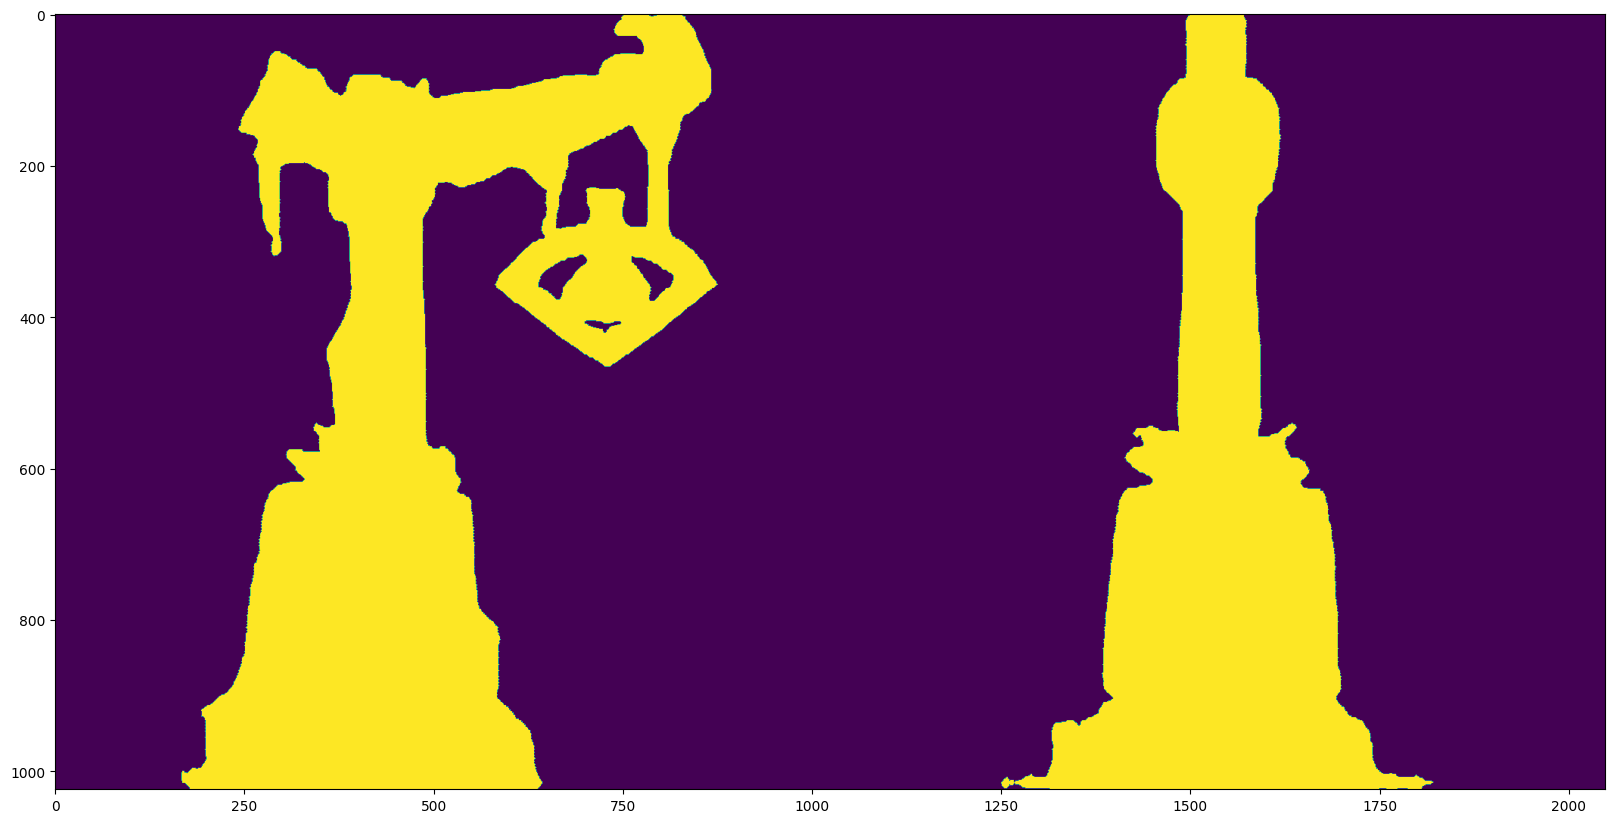

In [8]:
import numpy as np
import trimesh
from PIL import Image, ImageDraw

from custom_nodes.comfywr_nodes.nodes import mesh_silhouette_images

mesh = trimesh.load(mesh_path)
original_mesh_silh = mesh_silhouette_images(mesh)
plt.figure(figsize=(20,20))
plt.imshow(np.concatenate(original_mesh_silh, 1))
plt.show()

(1024, 1024)


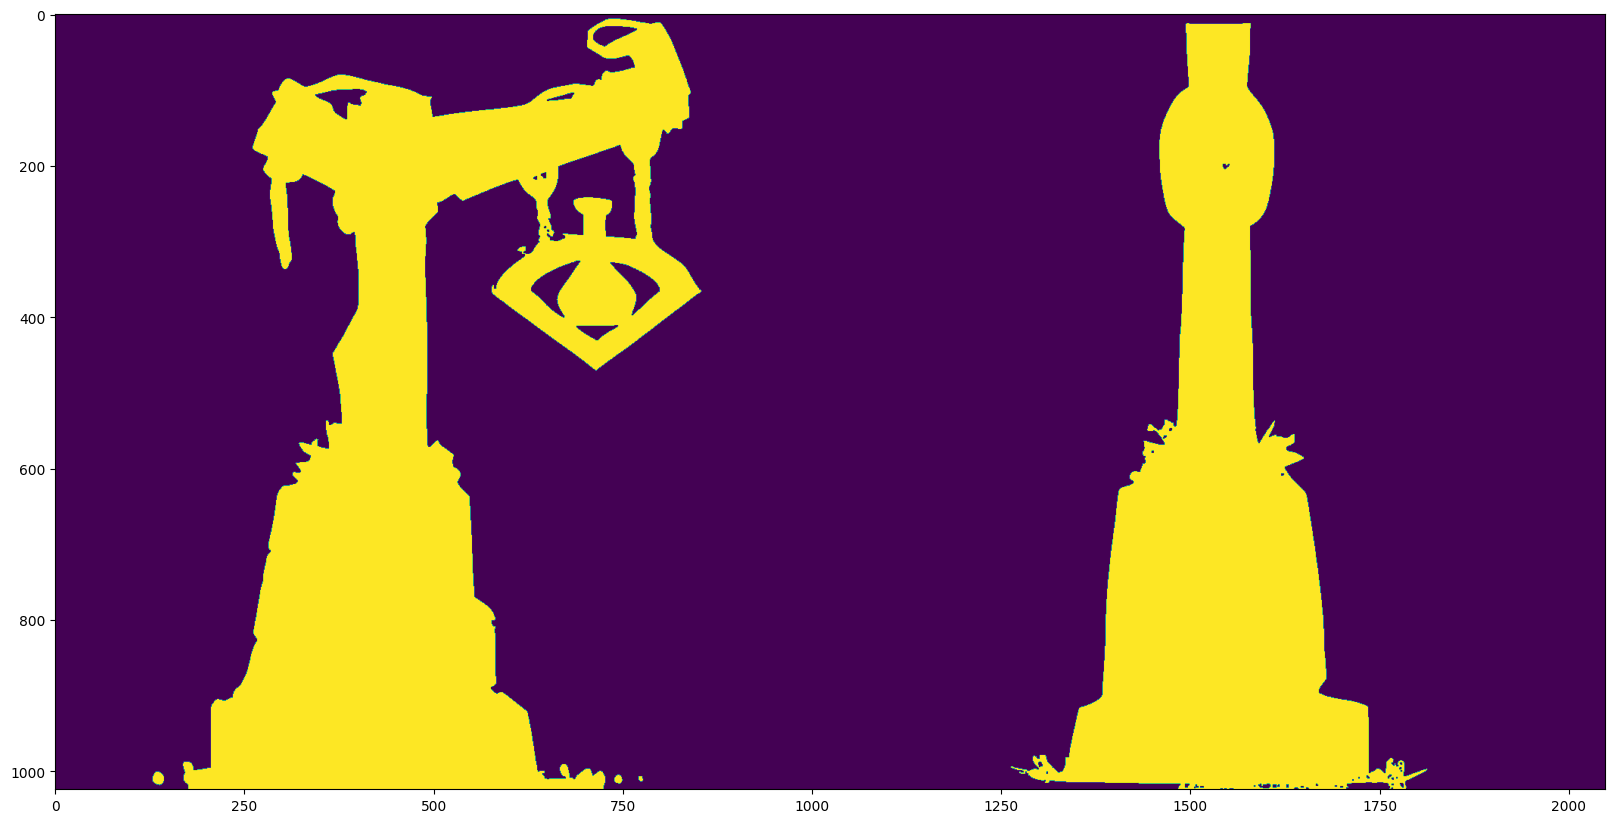

In [9]:
import cv2
target_silh = [
    cv2.imread('/workdir/ComfyUI/output/Unique3d_v2.1/silhouette_00041_.png')[:, :, 0],
    cv2.imread('/workdir/ComfyUI/output/Unique3d_v2.1/silhouette_00042_.png')[:, :, 0],
]
for i in range(2):
    target_silh[i] = cv2.resize(target_silh[i], (1024, 1024)) > 0
    
print(target_silh[0].shape)
plt.figure(figsize=(20,20))
plt.imshow(np.concatenate(target_silh, 1))
plt.show()

differential_evolution step 1: f(x)= 15458.13542175293
differential_evolution step 2: f(x)= 9741.448494911194
differential_evolution step 3: f(x)= 9741.448494911194
differential_evolution step 4: f(x)= 9741.448494911194
differential_evolution step 5: f(x)= 8900.609707832336
differential_evolution step 6: f(x)= 8900.609707832336
differential_evolution step 7: f(x)= 8900.609707832336
differential_evolution step 8: f(x)= 8900.609707832336
differential_evolution step 9: f(x)= 5433.111821174622
differential_evolution step 10: f(x)= 4997.675577163696
differential_evolution step 11: f(x)= 3964.7165060043335
differential_evolution step 12: f(x)= 3588.558090209961
differential_evolution step 13: f(x)= 3203.3307914733887
differential_evolution step 14: f(x)= 3203.3307914733887
differential_evolution step 15: f(x)= 3203.3307914733887
differential_evolution step 16: f(x)= 2798.845676422119
differential_evolution step 17: f(x)= 2798.845676422119
differential_evolution step 18: f(x)= 2798.8456764221

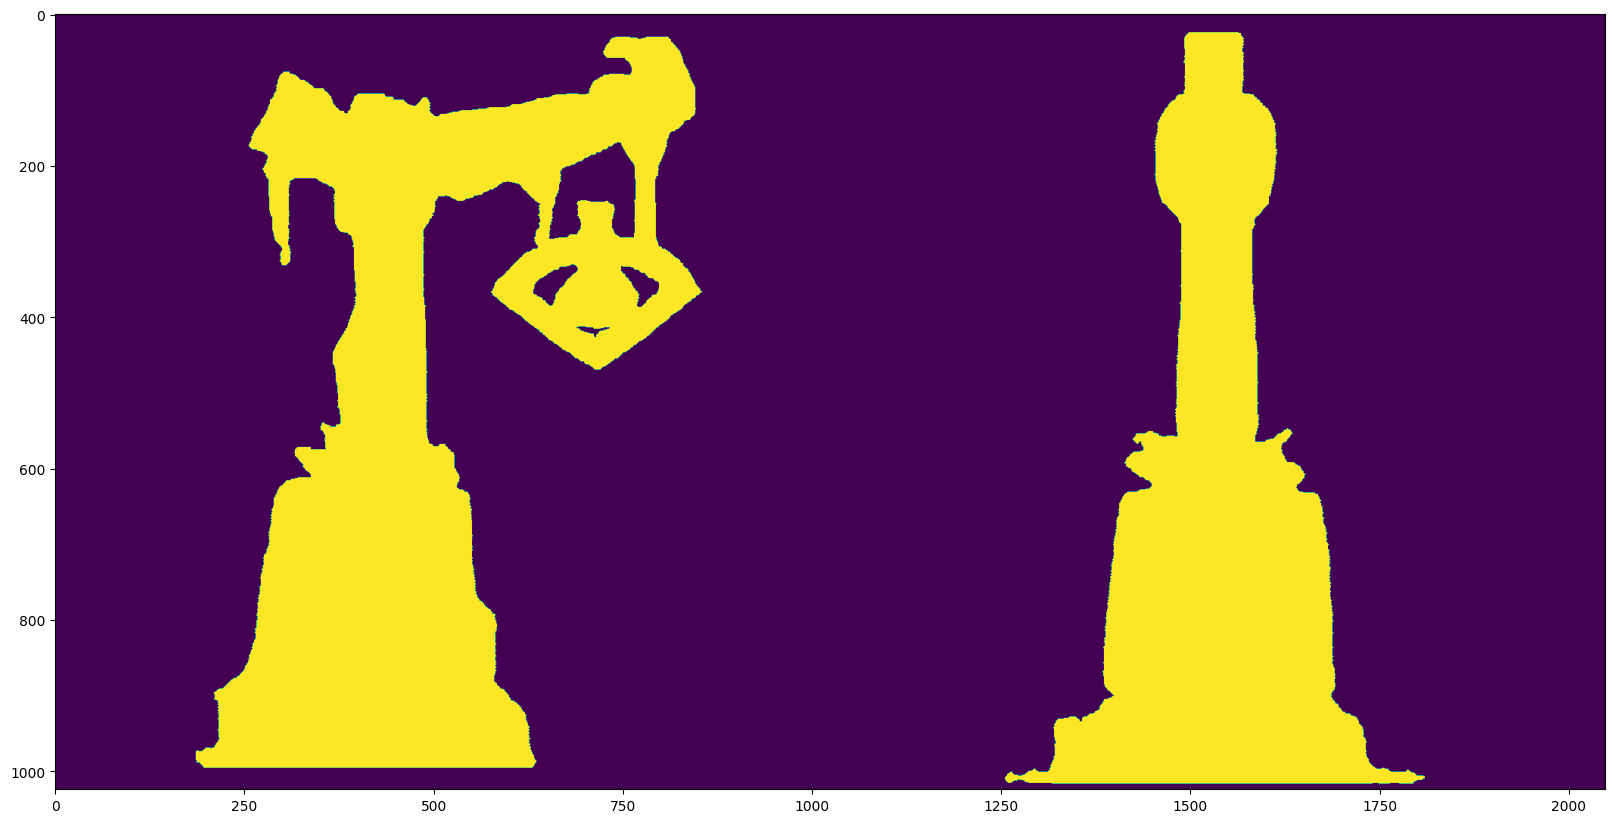

In [17]:
from custom_nodes.comfywr_nodes.nodes import align_images
aligned1, params1 = align_images(original_mesh_silh[0].astype(np.uint8) * 255,
                                target_silh[0].astype(np.uint8) * 255)
aligned2, params2 = align_images(original_mesh_silh[1].astype(np.uint8) * 255,
                                target_silh[1].astype(np.uint8) * 255)
print(params1.x, params2.x)
plt.figure(figsize=(20,20))
aligned_silh = [aligned1 > 0, aligned2 > 0]
plt.imshow(np.concatenate(aligned_silh, 1))
plt.show()

In [31]:
# scale = (params1.x[0] + params2.x[0]) / 2
scale = params1.x[0]
offset_x = params1.x[1]
# offset_y = (params1.x[2] + params2.x[2]) / 2
offset_y = params1.x[2]
offset_z = params2.x[1]

In [36]:
from custom_nodes.comfywr_nodes.nodes import transform_mesh
import trimesh
aligned_mesh = trimesh.load(mesh_path)
# aligned_mesh = transform_mesh(aligned_mesh, offset_x, offset_y, offset_z, *[scale] * 3)
aligned_mesh = transform_mesh(aligned_mesh, 0, 0, 0, *[scale] * 3)
aligned_mesh_slih = mesh_silhouette_images(aligned_mesh)

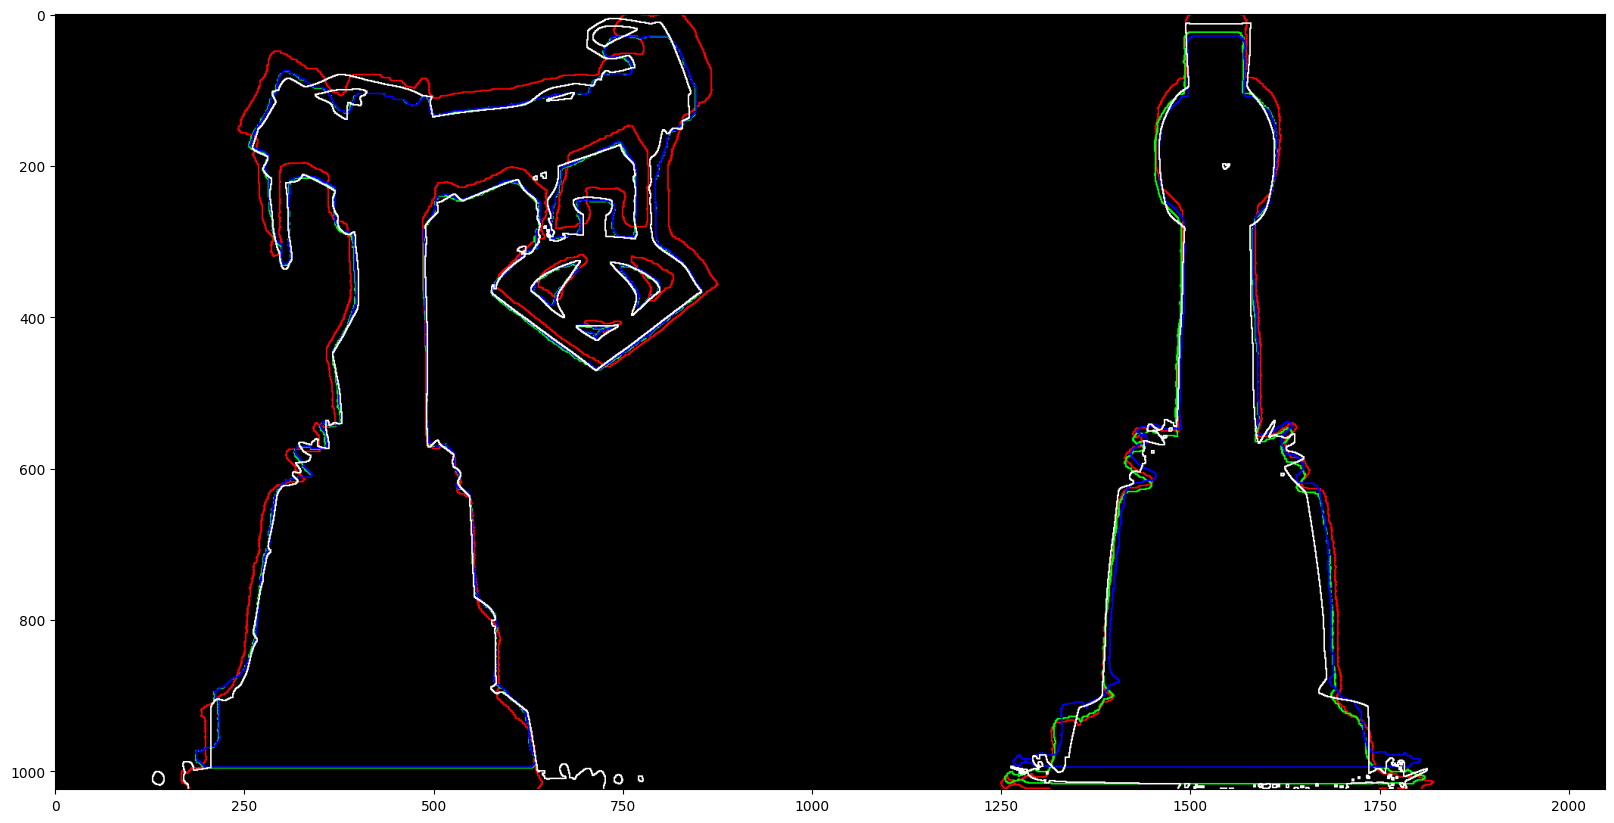

In [37]:
def visualize(silhouettes):
    vis = np.zeros((silhouettes[0][0].shape[0], silhouettes[1][1].shape[1] * 2, 3), dtype=np.uint8)
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 255)]
    for s, col in zip(silhouettes, colors):
        assert 0 < np.mean(s) < 1
        mask = np.concatenate(s, 1).astype(np.uint8) * 255
        assert mask.shape == vis.shape[:2]
        edges = cv2.dilate(mask, np.ones((3, 3))) - cv2.erode(mask, np.ones((3, 3)))
        vis[edges > 0] = col
    plt.figure(figsize=(20,20))
    plt.imshow(vis)
    plt.show()

visualize([original_mesh_silh, aligned_silh, aligned_mesh_slih, target_silh])